# **Dataset Preparation**

### Install `wfdb` Library

This code installs the `wfdb` Python library, which is used for reading, writing, and processing physiological signal data (such as ECG or other bio-signals). 

- The `!pip install -q wfdb` command is used to install the `wfdb` library via pip in a Jupyter notebook or similar environment.
- The `-q` flag stands for "quiet" mode, which suppresses most of the installation output for a cleaner experience.
  
By running this cell, the `wfdb` library will be available for use in subsequent code cells.


In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 4.8 MB/s eta 0:00:00


### Import library

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import resample
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.optimizers import Adam 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from sklearn.preprocessing import StandardScaler

## *Datasets*

### 1. [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/)
- *Description:* Contains normal sinus rhythm ECG signals.  
- *Sampling Frequency:* 360 Hz.  
- *Leads:* MLII and V1.  
- *Files:*
  - .atr → Annotation file.  
  - .dat → Information about the beats.  
  - .header → Metadata of the file record.


In [3]:
# Define the file path
file_path = "/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/RECORDS"

try:
    # Open the file and read all lines
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Clean the data by removing any leading/trailing whitespace
    cleaned_data = [line.strip() for line in lines]

    # Display the cleaned data
    print(cleaned_data)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [4]:
def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/{name}"  # Adjust path as needed
        try:
            record = wfdb.rdrecord(record_name, channels=[0])  # Load lead 0 (MLII)
            annotation = wfdb.rdann(record_name, 'atr')

            # Extract signal and sampling frequency
            signal = record.p_signal.flatten()  # Convert 2D signal to 1D
            fs = record.fs  # 360 Hz for MIT-BIH

            # Get R-peak locations and annotations
            r_peaks = annotation.sample
            labels = annotation.symbol
            
            # Define window size (0.6 seconds * fs)
            window_size = int(0.6 * fs)  # 216 samples at 360 Hz
            
            for i in range(1, len(r_peaks) - 1):  # Ignore first & last beats
                start = max(0, r_peaks[i] - window_size // 2)
                end = min(len(signal), r_peaks[i] + window_size // 2)
                beat = signal[start:end]
                
                # Append only if the extracted beat matches the window size
                if len(beat) == window_size:
                    beats.append(beat)
                    beat_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue

    return beat_labels, beats

# Your record list
record_list = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
               '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
               '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
               '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
               '222', '223', '228', '230', '231', '232', '233', '234']

# Extract beats and labels
labels, extracted_beats = extract_beats_from_multiple_files(record_list)

# Basic validation
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")

Total beats extracted: 112532
Total labels: 112532
Length of first beat: 216


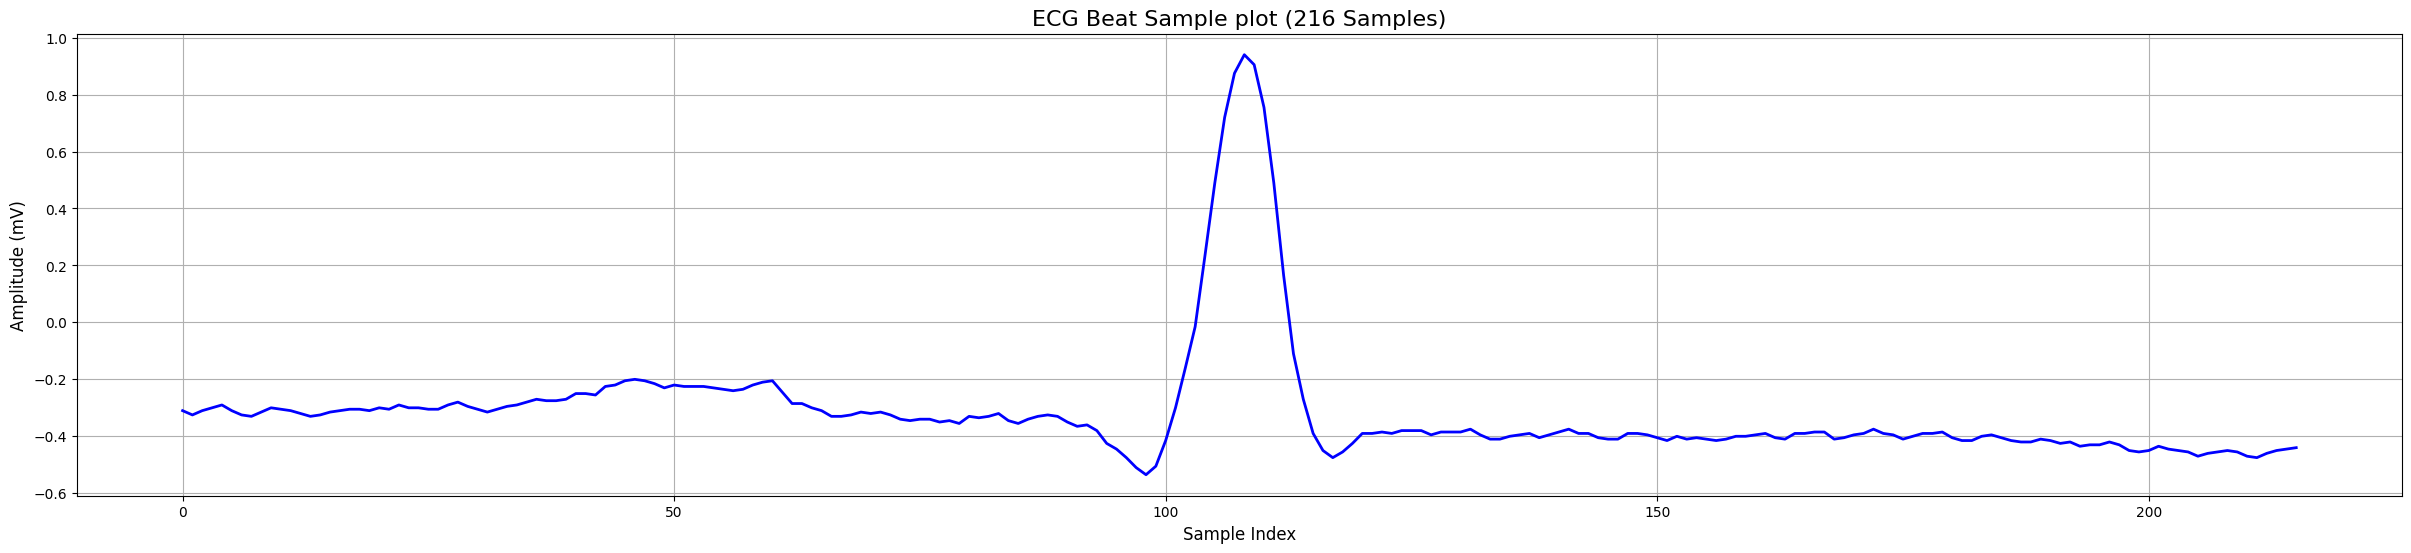

In [5]:
# Create the plot
plt.figure(figsize=(30, 6))  # Set figure size to (30, 6)
plt.plot(extracted_beats[0], linewidth=2, color='blue')  # Plot the ECG beat
plt.title('ECG Beat Sample plot (216 Samples)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True)  # Add a grid for better readability
plt.show()

In [6]:
# Convert beats to a NumPy array with 216 columns
print("Converting beats to array...")
signals = np.array(extracted_beats)  # Shape: (~108,000, 216)

# Create DataFrame with 216 signal columns and 1 label column
print("Creating DataFrame with 217 columns...")
signal_columns = [f"signal_{i}" for i in range(216)]  # Column names: signal_0, signal_1, ..., signal_215
df = pd.DataFrame(signals, columns=signal_columns)
df["label"] = labels  # Add label column

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(216)]].values
labels_loaded = df_loaded["label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 217 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (112532, 217)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0    -0.310    -0.325    -0.310    -0.300    -0.290     -0.31    -0.325   
1    -0.330    -0.335    -0.355    -0.360    -0.355     -0.35    -0.340   
2    -0.365    -0.380    -0.370    -0.365    -0.350     -0.35    -0.350   
3    -0.320    -0.340    -0.340    -0.350    -0.365     -0.36    -0.345   
4    -0.335    -0.355    -0.345    -0.340    -0.335     -0.32    -0.325   

   signal_7  signal_8  signal_9  ...  signal_207  signal_208  signal_209  \
0    -0.330    -0.315    -0.300  ...      -0.455      -0.450      -0.455   
1    -0.345    -0.345    -0.345  ...      -0.425      -0.425      -0.415   
2    -0.370    -0.365    -0.345  ...      -0.370      -0.365      -0.370   
3    -0.345    -0.350    -0.350  ...      -0.450      -0.445      -0.430   
4   

In [7]:
target_classes = ['N', 'V', 'F', 'Q']
df["label"] = df["label"].apply(lambda x: x if x in target_classes else 'Q')
df.to_csv("mitbih_beats_relabeled.csv", index=False)

In [8]:
df['label'].value_counts()

label
N    75005
Q    29596
V     7129
F      802
Name: count, dtype: int64

In [9]:
print("Encoding labels manually...")
label_mapping = {'N': 0, 'V': 1, 'F': 2, 'Q': 3}  # Custom mapping
df["label"] = df["label"].map(label_mapping)

Encoding labels manually...


In [10]:
df.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_207,signal_208,signal_209,signal_210,signal_211,signal_212,signal_213,signal_214,signal_215,label
0,-0.310,-0.325,-0.310,-0.300,-0.290,-0.31,-0.325,-0.330,-0.315,-0.300,...,-0.455,-0.450,-0.455,-0.470,-0.475,-0.460,-0.450,-0.445,-0.44,0
1,-0.330,-0.335,-0.355,-0.360,-0.355,-0.35,-0.340,-0.345,-0.345,-0.345,...,-0.425,-0.425,-0.415,-0.395,-0.395,-0.390,-0.375,-0.360,-0.34,0
2,-0.365,-0.380,-0.370,-0.365,-0.350,-0.35,-0.350,-0.370,-0.365,-0.345,...,-0.370,-0.365,-0.370,-0.375,-0.350,-0.335,-0.320,-0.315,-0.32,0
3,-0.320,-0.340,-0.340,-0.350,-0.365,-0.36,-0.345,-0.345,-0.350,-0.350,...,-0.450,-0.445,-0.430,-0.420,-0.410,-0.425,-0.420,-0.405,-0.38,0
4,-0.335,-0.355,-0.345,-0.340,-0.335,-0.32,-0.325,-0.350,-0.330,-0.315,...,-0.435,-0.435,-0.445,-0.440,-0.450,-0.430,-0.430,-0.415,-0.40,0


# **CNN Model Training**

In [11]:
print(f"The Shape of the data: {df.shape}")

The Shape of the data: (112532, 217)


## Visualizing Class Distribution in the ECG Dataset
This cell generates a **pie chart** to visualize the proportion of **normal vs. abnormal ECG beats** in the dataset.

### Steps Involved:
    1. Counting Instances of Each Class

        * data.iloc[:, -1].value_counts() retrieves the count of normal (0) and abnormal (1) beats from the last column of the dataset.
        * The result is stored in per_classes.
    2. Creating the Pie Chart

    * A figure of size (20,10) is created for better visibility.
    * The plt.pie() function is used to generate the chart:
        * Labels: ['Normal', 'Abnormal'] to distinguish between classes.
        * Colors: tab:blue for normal and tab:orange for abnormal beats.
        * Percentage Display: autopct='%1.1f%%' shows the percentage of each class in the dataset.
3. Displaying the Chart

    * plt.show() renders the pie chart.
### Purpose of This Visualization
    * Helps in understanding class imbalance in the dataset.
    * Provides insight into the distribution of normal vs. abnormal heartbeats, which is crucial for model performance and bias mitigation.

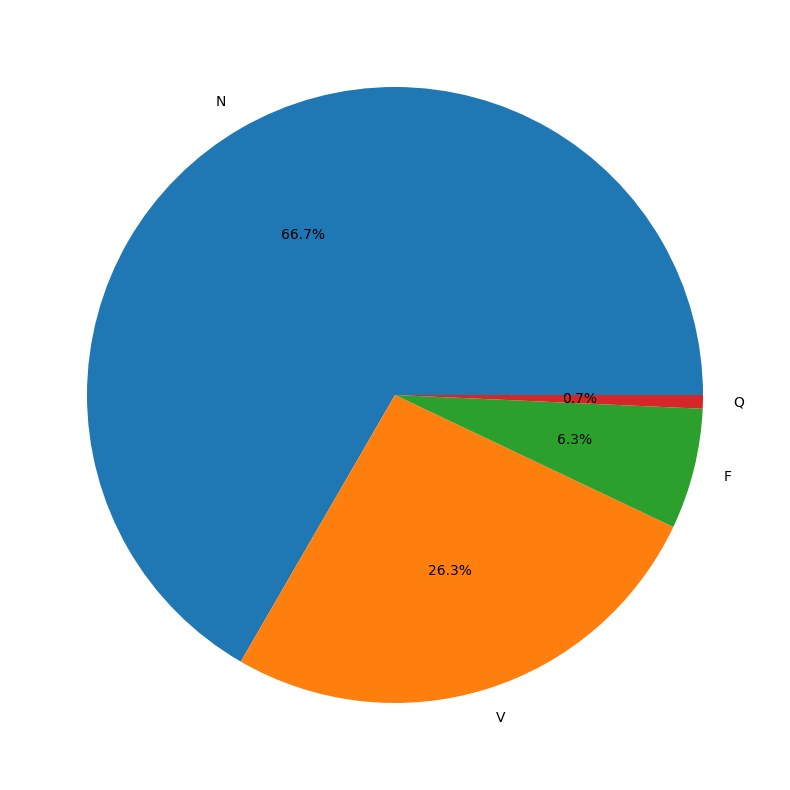

In [12]:
per_classes = df.iloc[:, -1].value_counts()
plt.figure(figsize=(20,10))
plt.pie(per_classes, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
plt.show()

In [13]:
df.iloc[:, -1].value_counts()

label
0    75005
3    29596
1     7129
2      802
Name: count, dtype: int64

In [14]:
X = df.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_206,signal_207,signal_208,signal_209,signal_210,signal_211,signal_212,signal_213,signal_214,signal_215
0,-0.310,-0.325,-0.310,-0.300,-0.290,-0.31,-0.325,-0.330,-0.315,-0.300,...,-0.460,-0.455,-0.450,-0.455,-0.470,-0.475,-0.460,-0.450,-0.445,-0.44
1,-0.330,-0.335,-0.355,-0.360,-0.355,-0.35,-0.340,-0.345,-0.345,-0.345,...,-0.420,-0.425,-0.425,-0.415,-0.395,-0.395,-0.390,-0.375,-0.360,-0.34
2,-0.365,-0.380,-0.370,-0.365,-0.350,-0.35,-0.350,-0.370,-0.365,-0.345,...,-0.385,-0.370,-0.365,-0.370,-0.375,-0.350,-0.335,-0.320,-0.315,-0.32
3,-0.320,-0.340,-0.340,-0.350,-0.365,-0.36,-0.345,-0.345,-0.350,-0.350,...,-0.445,-0.450,-0.445,-0.430,-0.420,-0.410,-0.425,-0.420,-0.405,-0.38
4,-0.335,-0.355,-0.345,-0.340,-0.335,-0.32,-0.325,-0.350,-0.330,-0.315,...,-0.445,-0.435,-0.435,-0.445,-0.440,-0.450,-0.430,-0.430,-0.415,-0.40


In [15]:
y = df.iloc[:, -1]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [16]:
print(f"The Shape of the X: {X.shape}")
print(f"The Shape of the y: {y.shape}")

The Shape of the X: (112532, 216)
The Shape of the y: (112532,)


In [17]:
# count of the classes
y.value_counts().reset_index()

,label,count
0,0,75005
1,3,29596
2,1,7129
3,2,802


In [18]:
# First split: 80% train+validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 60% train, 20% validation (0.25 of 80% = 20% of total)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [19]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (67518, 216)
The shape of X_test: (22507, 216)
The shape of X_valid: (22507, 216)
The length of y_train: 67518
The length of y_test: 22507
The shape of y_valid: 22507


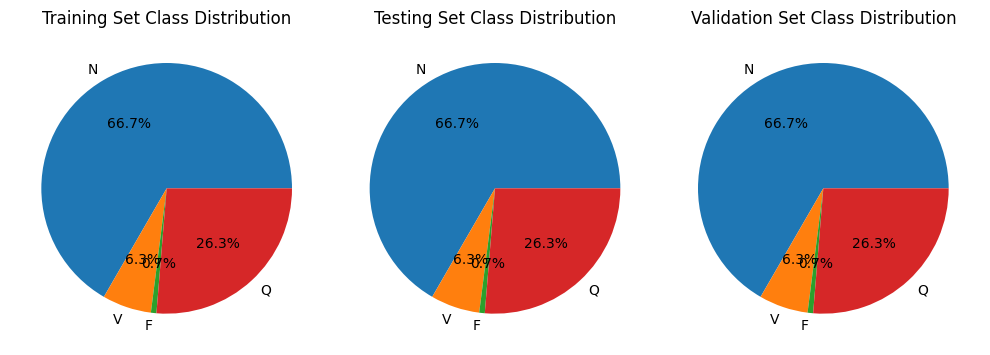

In [20]:
# Compute class distributions for training and testing sets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
valid_classes, valid_counts = np.unique(y_valid, return_counts=True)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(10, 8))

# Plot the Training Set Distribution
axes[0].pie(train_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[0].set_title('Training Set Class Distribution')

# Plot the Testing Set Distribution
axes[1].pie(test_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[1].set_title('Testing Set Class Distribution')

# Plot the Testing Set Distribution
axes[2].pie(valid_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[2].set_title('Validation Set Class Distribution')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [21]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))
# X_test = np.array(X_test)

# print(type(y_train))

(67518, 216, 1)
<class 'numpy.ndarray'>
(22507, 216, 1)
<class 'numpy.ndarray'>
(22507, 216, 1)
<class 'numpy.ndarray'>


In [22]:
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(67518,)
(22507,)
(22507,)


In [23]:
train_y=to_categorical(y_train)
test_y=to_categorical(y_test)
valid_y=to_categorical(y_valid)
print(np.shape(train_y), np.shape(test_y), np.shape(valid_y))

(67518, 4) (22507, 4) (22507, 4)


In [24]:
train_x = np.array(train_x, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)

test_x = np.array(test_x, dtype=np.float32)
test_y = np.array(test_y, dtype=np.float32)

valid_x = np.array(valid_x, dtype=np.float32)
valid_y = np.array(valid_y, dtype=np.float32)

### Model Architecture Definition
This section defines a **1D Convolutional Neural Network (CNN)** for ECG classification.
The model consists of:

1. **Four Convolutional Layers** with increasing filters (16 → 32 → 64 → 128) to extract ECG signal features.
2. **Max Pooling Layers** to reduce spatial dimensions and computational complexity.
3. **Flattening Layer** to convert feature maps into a single vector.
4. **Fully Connected Layers** with **Dropout (0.5, 0.4, 0.3)** to prevent overfitting.
5. **Output Layer** with a **sigmoid activation** for binary classification (Normal vs. Abnormal ECG).

In [25]:
# Function to build the CNN model for ECG classification
model = Sequential()

# First Convolutional Layer with 16 filters, kernel size 11, ReLU activation, and same padding
model.add(Conv1D(filters=16, kernel_size=11, strides=1, padding='same', activation='relu', input_shape=(216, 1)))
model.add(MaxPooling1D(pool_size=5, strides=2))  # Max pooling to reduce dimensionality

# Second Convolutional Layer with 32 filters
model.add(Conv1D(filters=32, kernel_size=13, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Third Convolutional Layer with 64 filters
model.add(Conv1D(filters=64, kernel_size=15, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Fourth Convolutional Layer with 128 filters
model.add(Conv1D(filters=128, kernel_size=17, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Flattening the feature maps into a single vector
model.add(Flatten())

# Fully connected layers with Dropout for regularization
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
model.add(Dense(4, activation='softmax'))

# Display model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 216, 16)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 106, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 106, 32)             │           6,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 51, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 51, 64)              │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 24, 128)             │         139,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         128,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,410 (1.18 MB)

 Trainable params: 310,410 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation
This section **compiles** the CNN model with:  
- **Loss Function:** `binary_crossentropy` (since it's a binary classification task).  
- **Optimizer:** `Adam` with a learning rate of `0.0001` for efficient learning.  
- **Metric:** `accuracy`, which evaluates how well the model is performing.  

In [26]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(
    loss='categorical_crossentropy',  # Suitable for binary classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy']  # Track accuracy during training
)

### Early Stopping Mechanism
To **prevent overfitting**, `EarlyStopping` is used:  
- **Monitors Validation Loss** (`val_loss`) to track generalization.  
- **Stops Training if No Improvement in 5 Consecutive Epochs** (`patience=5`).  
- **Restores Best Weights** (`restore_best_weights=True`) to keep the most optimal model.  

In [27]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model weights after stopping
)

### Saving the Best Model in HDF5 Format

1. **Using ModelCheckpoint Callback**
   - Saves the best model based on **validation loss** (`val_loss`).
   - Ensures only the best-performing model (lowest `val_loss`) is saved.
   - The model is saved in **HDF5 format (`.h5`)**, which supports model architecture, weights, and optimizer state.

2. **Parameters in `ModelCheckpoint`**
   - `filepath='best_ecg_model.h5'` → Saves the model with this filename.
   - `monitor='val_loss'` → Tracks validation loss for saving.
   - `save_best_only=True` → Saves only the best model, preventing storage of unnecessary models.
   - `mode='min'` → Saves the model when `val_loss` decreases.

In [28]:
# Define a ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_ecg_model.keras',  # Change the extension to .keras
    monitor='val_loss',              # Monitor validation loss
    save_best_only=True,             # Save only the best model based on val_loss
    mode='min',                      # Save model when val_loss is minimized
    verbose=1                        # Print a message when saving the model
)


### Model Training Process
The model is trained on `X_train` and `y_train` using:  
- **Batch Size:** `42` (controls how many samples are processed before updating weights).  
- **Epochs:** `50` (maximum training cycles).  
- **Validation Data:** `(X_test, y_test)` for tracking model performance on unseen data.  
- **Early Stopping Callback:** Helps prevent unnecessary training when validation loss stops improving.  

In [29]:
# Train the model
history = model.fit(
    train_x, train_y,
    batch_size=42,  # Number of samples per batch
    epochs=50,  # Train for up to 50 epochs
    verbose=1,  # Show training progress
    validation_data=(valid_x, valid_y),  # Validate on test data
    callbacks=[early_stopping, checkpoint]  # Apply early stopping and checkpoint
)

Epoch 1/50
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7749 - loss: 0.6156
Epoch 1: val_loss improved from inf to 0.15530, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.7749 - loss: 0.6155 - val_accuracy: 0.9552 - val_loss: 0.1553
Epoch 2/50
1606/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.1777
Epoch 2: val_loss improved from 0.15530 to 0.11390, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9520 - loss: 0.1777 - val_accuracy: 0.9685 - val_loss: 0.1139
Epoch 3/50
1600/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9667 - loss: 0.1240
Epoch 3: val_loss improved from 0.11390 to 0.08848, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9667 - loss: 0.1240 - val_accuracy: 0.9747 - val_loss: 0.0885
Epoch 4/50
1606/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - loss: 0.1035
Epoch 4: val_loss improve

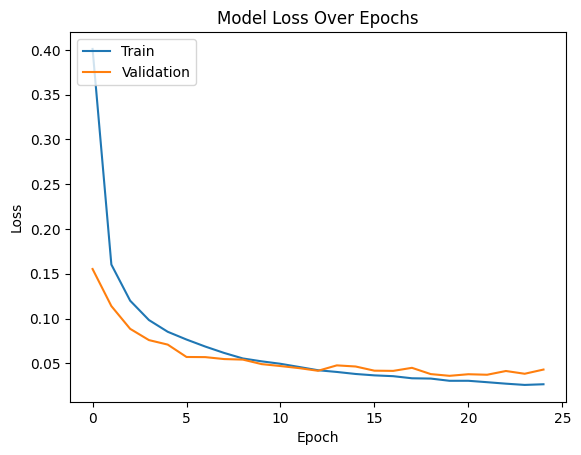

In [30]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Set the title and axis labels
plt.title('Model Loss Over Epochs')  # Title of the plot
plt.ylabel('Loss')  # Y-axis label (Loss)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation loss
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')

# Display the plot
plt.show()

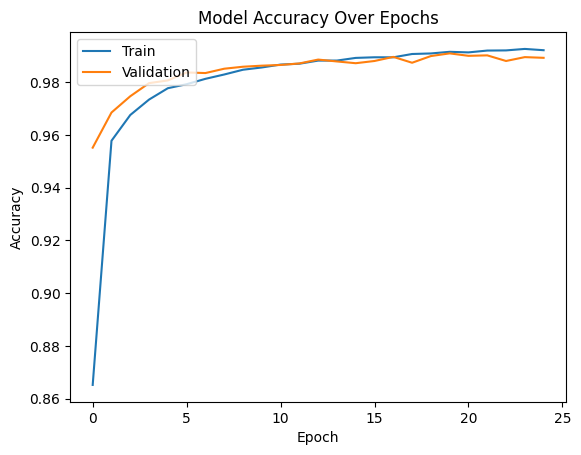

In [31]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy

# Set the title and axis labels
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label (Accuracy)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation accuracy
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')

# Display the plot
plt.show()

In [32]:
model.predict(test_x)

704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[7.8876914e-12, 6.5077425e-13, 3.1250821e-17, 1.0000000e+00],
       [9.9998677e-01, 9.3305800e-08, 1.3120416e-06, 1.1818109e-05],
       [2.7913884e-06, 1.5058671e-06, 7.8081106e-09, 9.9999571e-01],
       ...,
       [2.3719007e-03, 3.6864376e-04, 2.7067375e-05, 9.9723238e-01],
       [4.8308897e-07, 3.1932302e-07, 8.6327667e-10, 9.9999917e-01],
       [9.9806386e-01, 5.0828439e-05, 2.5928128e-04, 1.6260982e-03]],
      dtype=float32)

In [33]:
# Evaluate the trained model on the test dataset
score = model.evaluate(test_x, test_y)

# Print the test loss
print(f'Test Loss: {score[0]:.4f}')  # Display test loss with 4 decimal precision

# Print the test accuracy
print(f'Test Accuracy: {score[1] * 100:.2f}%')

704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9900 - loss: 0.0377
Test Loss: 0.0378
Test Accuracy: 98.92%


704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


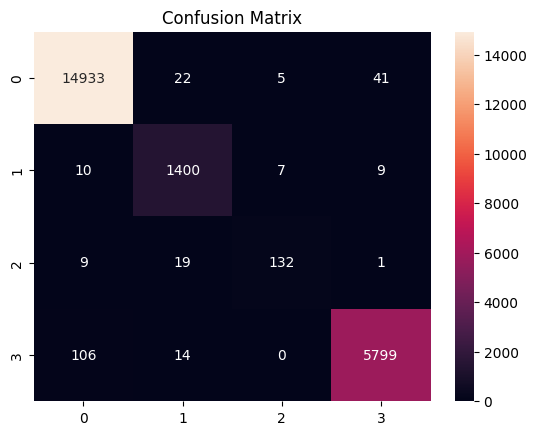

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d',ax=ax)
ax.set_title('Confusion Matrix'); 
plt.savefig('cm')

In [35]:
from sklearn.metrics import classification_report

cf = classification_report(y_true, prediction,digits=4)
print(cf)

              precision    recall  f1-score   support

           0     0.9917    0.9955    0.9936     15001
           1     0.9622    0.9818    0.9719      1426
           2     0.9167    0.8199    0.8656       161
           3     0.9913    0.9797    0.9855      5919

    accuracy                         0.9892     22507
   macro avg     0.9655    0.9442    0.9541     22507
weighted avg     0.9892    0.9892    0.9892     22507

